In [7]:
import numpy as np
import utils
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras.layers import LSTM, Input, Dense
from keras.models import Model


In [8]:
nb_features = 4
hidden_size = 2
train_max_timesteps = 50
test_max_timesteps = 100
train_samples = 100
test_samples = 100
epochs = 50

# Building Synthetic Dataset

In [9]:
X_train, Y_train = utils.build_dataset(nb_features, train_max_timesteps, train_samples)
X_test, Y_test = utils.build_dataset(nb_features, test_max_timesteps, train_samples)

# Defining and training simple GRU model

In [27]:
model = Sequential()
model.add(LSTM(hidden_size, input_shape=(None, nb_features), return_sequences=True))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=epochs, verbose=0)

# Select a random TS in the training set and prints the prediction of the GRU at each timestep (the model has clearly overfitted)

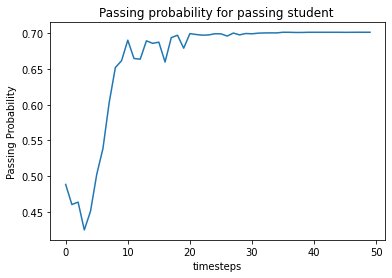

In [28]:
i=np.random.randint(0,train_samples)
label = 'passing' if Y_train[i][0][0] == 1 else 'failing'
timesteps = [_ for _ in range(train_max_timesteps)]

TS = tf.reshape(X_train[i], [1, train_max_timesteps, nb_features])

output = model.predict(TS, verbose=0)
output = tf.reshape(output, [train_max_timesteps])
proba = tf.math.sigmoid(output).numpy()

plt.plot(timesteps, proba)
plt.xlabel('timesteps')
plt.ylabel('Passing Probability')
plt.title(f"Passing probability for {label} student ")
plt.show()

# tf.math.sigmoid(output[i]),Y_train[i]

# Select a random TS in the test set and prints the prediction of the GRU at each timestep (the length of sequences are longer than in the training set)

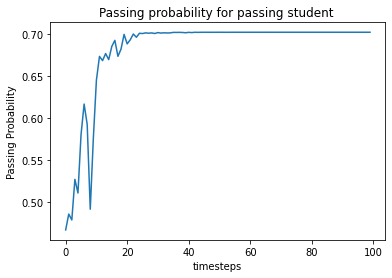

In [29]:
i=np.random.randint(0,test_samples)
label = 'passing' if Y_test[i][0][0] == 1 else 'failing'
timesteps = [_ for _ in range(test_max_timesteps)]

TS = tf.reshape(X_test[i], [1, test_max_timesteps, nb_features])

output = model.predict(TS, verbose=0)
output = tf.reshape(output, [test_max_timesteps])
proba = tf.math.sigmoid(output).numpy()
plt.plot(timesteps, proba)
plt.xlabel('timesteps')
plt.ylabel('Passing Probability')
plt.title(f"Passing probability for {label} student ")
plt.show()

# tf.math.sigmoid(output[i]),Y_train[i]

# Now let us try the model on a random TS with an arbitrary length

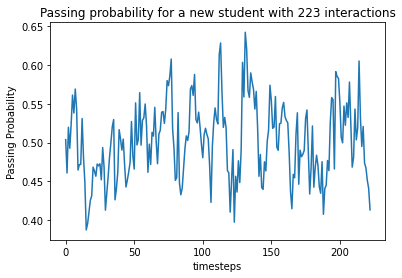

In [30]:
length=np.random.randint(1, 10*train_max_timesteps)

timesteps = [_ for _ in range(length)]

TS = tf.random.normal([1, length, nb_features])

output = model.predict(TS, verbose=0)
output = tf.reshape(output, [length])
proba = tf.math.sigmoid(output).numpy()

plt.plot(timesteps, proba)
plt.xlabel('timesteps')
plt.ylabel('Passing Probability')
plt.title(f"Passing probability for a new student with {length} interactions")
plt.show()

# Now let's compute the outputs of a TS, observe a new interaction and compute the new output without having to re-process the entire TS with the GRU. 

Vinitra is that what you meant this afternoon or did I misunderstant? Also, I used a GRU to avoid deadline with hte additional cell state of the LSTM. Is that what you were refering to?

In [31]:
"""Apply hte model to the entire sequence"""
TS = tf.random.normal([1, 5, nb_features])
output = model(TS).numpy()
print(output)

[[[-0.23539254]
  [-0.30003953]
  [-0.18717524]
  [-0.4620807 ]
  [-0.3286588 ]]]


In [32]:
"""Save the last prediction and the last interaction"""
last_prediction = output[:, -1, :]
last_interaction = TS[:, -1:, :]
last_prediction, last_interaction

(array([[-0.3286588]], dtype=float32),
 <tf.Tensor: shape=(1, 1, 4), dtype=float32, numpy=
 array([[[-0.40790263,  0.20025927,  0.5423129 ,  0.9804183 ]]],
       dtype=float32)>)

In [33]:
"""Remove the last interaction and pass the GRU again"""
TS = TS[:, :-1, :]
hidden_states = model.layers[0](TS)
last_hidden_state = hidden_states[:, -1,:]
outputs = model.layers[1](hidden_states)
print(hidden_states)
print(outputs)

tf.Tensor(
[[[ 0.06568336 -0.07334059]
  [ 0.1591923  -0.04442583]
  [ 0.03887635 -0.04786472]
  [ 0.35247806 -0.01697813]]], shape=(1, 4, 2), dtype=float32)
tf.Tensor(
[[[-0.23539254]
  [-0.30003953]
  [-0.18717524]
  [-0.4620807 ]]], shape=(1, 4, 1), dtype=float32)


In [36]:
"""Use the last hidden state and the last interaction to predict the next output"""
final_hidden_state = model.layers[0](last_interaction, initial_state=(last_hidden_state))
final_prediction = model.layers[1](final_hidden_state).numpy()

ValueError: Exception encountered when calling layer "lstm_4" (type LSTM).

Layer has 2 states but was passed 1 initial states. Received: initial_state=[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.35247806, -0.01697813]], dtype=float32)>]

Call arguments received:
  • inputs=tf.Tensor(shape=(1, 1, 4), dtype=float32)
  • mask=None
  • training=None
  • initial_state=['tf.Tensor(shape=(1, 2), dtype=float32)']

We have the same values, it is working

In [ ]:
final_prediction, last_prediction